# Missile Example Study

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
from collections import defaultdict
from pathlib import Path
from typing import Any
from typing import Dict
from tqdm.notebook import trange, tqdm

### Setup Paths

In [2]:
    # Replace these with your own paths...
data_path = Path(os.getcwd()) / Path("data/scenario001")
scenario_path = data_path / Path("scenario001.json")
results_path = os.getcwd()

### Setup ACE ZEro

In [3]:
import ace_zero_core
from ace_zero_core import acezero
from ace_zero_core.agents.bt_agent.btpilot import BTPilot, BehaviorType
from ace_zero_core.agents.bt_agent.behaviors.tacparams import TacticalParameters
from ace_zero_core.utils import nautical_miles_to_metres as nmi_to_m
from ace_zero_core.utils import feet_to_metres as ft_to_m

### Missile Launch Range and Evasion Study

In [4]:
def set_initial_conditions(
    az: acezero.ACEZero,
    run: int,
    blue_behavior: BehaviorType,
    blue_tactics: TacticalParameters, 
    red_behavior: BehaviorType,
    red_tactics: TacticalParameters
) -> None:
    """
    ...
    """
    f1, f2 = az.get_entities()
    
    f1.set_position(x=-30000.0, y=000.0, z=5000.0)
    f1.set_orientation(psi=0.0, theta=0.0, phi=0.0)
    f1.set_speed(v=300.0)
    f1.set_desired_speed(v_c=300.0)
    f1.sensor.fov = 120.0
    f1.sensor.max_range = 2 * 50000.0
    f1.reset_mission()

    f2.set_position(x=20000.0, y=1000.0, z=5000.0)
    f2.set_orientation(psi=180.0, theta=0.0, phi=0.0)
    f2.set_speed(v=300.0)
    f2.set_desired_speed(v_c=300.0)
    f2.sensor.fov = 120.0
    f2.sensor.max_range = 2 * 50000.0
    f2.reset_mission()
    
    f1.pilot = ace_zero_core.agents.bt_agent.btpilot.BTPilot(blue_behavior)
    f1.pilot.set_tactics(blue_tactics)
    
    f2.pilot = ace_zero_core.agents.bt_agent.btpilot.BTPilot(red_behavior)
    f2.pilot.set_tactics(red_tactics)

In [5]:
summary_features = [
    "run_number",
    "total_run_time",
    "viper_briefed_behavior",
    "viper_briefed_launch_range",
    "viper_briefed_evasion_range",
    "viper_alive",
    "cobra_briefed_behavior",
    "cobra_briefed_launch_range",
    "cobra_briefed_evasion_range",
    "cobra_alive",
    "outcome",
    "viper_launched",
    "viper_launch_range",
    "viper_time_at_launch",
    "cobra_launched",
    "cobra_launch_range",
    "cobra_time_at_launch",
]

In [6]:
def add_run_summary(
    run_number: int, 
    smd: Dict[str,Any], 
    results_df: pd.DataFrame,
    weapons_df: pd.DataFrame,
    tracks_df: pd.DataFrame,
    blue_behavior: BehaviorType,
    blue_tactics: TacticalParameters,
    red_behavior: BehaviorType,
    red_tactics: TacticalParameters
) -> None:
    """
    Create run summary.
    """
    smd["run_number"].append(run_number)
    
        # Start with extracting out new dataframes for viper and cobra
    viper_df = results_df[results_df.callsign == 'viper'].set_index('timestep')
    cobra_df = results_df[results_df.callsign == 'cobra'].set_index('timestep')

        # Get total run time
    results_last_row = results_df.iloc[-1]
    total_run_time = results_last_row['timestep']
    smd['total_run_time'].append(total_run_time)

        # Extract dataframes at time 0
    viper_df0 = viper_df.iloc[0]
    cobra_df0 = cobra_df.iloc[0]
    
        # Extract dataframes for last timestep
    viper_df_final = viper_df.iloc[-1]
    cobra_df_final = cobra_df.iloc[-1]
    
        # Behaviors and Tactical Parameters
    smd["viper_briefed_behavior"].append(blue_behavior)
    smd["viper_briefed_launch_range"].append(blue_tactics.launch_range)
    smd["viper_briefed_evasion_range"].append(blue_tactics.evasion_range)
    smd["viper_alive"].append(viper_df_final["alive"])
    
    smd["cobra_briefed_behavior"].append(red_behavior)
    smd["cobra_briefed_launch_range"].append(red_tactics.launch_range)
    smd["cobra_briefed_evasion_range"].append(red_tactics.evasion_range)
    smd["cobra_alive"].append(cobra_df_final["alive"])
    
        #
    outcome: str = "NONE"
    viper_alive = viper_df_final["alive"]
    cobra_alive = cobra_df_final["alive"]
    
    if viper_alive and cobra_alive:
        outcome = "BOTH_SURVIVED"
    if viper_alive and not cobra_alive:
        outcome = "VIPER_WIN"
    if not viper_alive and cobra_alive:
        outcome = "COBRA_WIN"
    if not viper_alive and not cobra_alive:
        outcome = "MUTUAL_KILL"
        
    smd["outcome"].append(outcome)
    
        # Setup weapon dataframes for viper and cobra
    wpn_viper0_filter = (weapons_df.launcher_callsign == 'viper') #& (weapons_df.weapon_id == 0)
    wpn_viper0 = weapons_df[wpn_viper0_filter]#.set_index('timestep')
    
    wpn_cobra0_filter = (weapons_df.launcher_callsign == 'cobra') #& (weapons_df.weapon_id == 0)
    wpn_cobra0 = weapons_df[wpn_cobra0_filter]#.set_index('timestep')
    
        # Now check to see if either of the aircraft have launched.
    viper_launches = wpn_viper0[wpn_viper0.wpn_status == "LAUNCH"]
    cobra_launches = wpn_cobra0[wpn_cobra0.wpn_status == "LAUNCH"]
    
    viper_launched = False
    viper_launch_range = -1.0
    viper_time_at_launch = -1.0
    
    if len(viper_launches):
        viper_launched = True
        viper_launch_range = viper_launches.target_range.iloc[0]
        viper_time_at_launch = viper_launches.timestep.iloc[0]
        
    smd["viper_launched"].append(viper_launched)
    smd["viper_launch_range"].append(viper_launch_range)
    smd["viper_time_at_launch"].append(viper_time_at_launch)
        
    cobra_launched = False
    cobra_launch_range = -1.0
    cobra_time_at_launch = -1.0

    if len(cobra_launches):
        cobra_launched = True
        cobra_launch_range = cobra_launches.target_range.iloc[0]
        cobra_time_at_launch = cobra_launches.timestep.iloc[0]
            
    smd["cobra_launched"].append(cobra_launched)
    smd["cobra_launch_range"].append(cobra_launch_range)
    smd["cobra_time_at_launch"].append(cobra_time_at_launch)

In [7]:
def run_msl_evasion_study(
        max_runs: int,
        min_lr: float,
        max_lr: float,
        min_er: float,
        max_er: float
    ) -> pd.DataFrame:
    """... """
    study_name = "msl_evasion-001"
    results_path = Path(os.getcwd() / Path(study_name))
    summary_dict = {feature : [] for feature in summary_features}
    
    for run_number in trange(1, max_runs + 1):
        az = acezero.ACEZero(
            scenario_uri=scenario_path, 
            results_path=results_path, 
            data_path=data_path, 
            run_number=run_number
        )
        
        blue_behavior = BehaviorType.ATTACK
        blue_tactics = TacticalParameters(
            launch_range = np.random.uniform(min_lr, max_lr),
            evasion_range = np.random.uniform(min_er, max_er)
        )
        
        red_behavior = BehaviorType.ATTACK
        red_tactics = TacticalParameters(
            launch_range = np.random.uniform(min_lr, max_lr),
            evasion_range = np.random.uniform(min_er, max_er)
        )

        set_initial_conditions(
            az = az, 
            run = run_number,
            blue_behavior = blue_behavior,
            blue_tactics = blue_tactics,
            red_behavior = red_behavior,
            red_tactics = red_tactics,
        )

        total_run_time = az.run_simulation()
        his_file_path, csv_file_path = az.process_results()
        weapons_csv_file_path = az.results.get_weapons_csv_filename()
        tracks_csv_file_path = az.results.get_tracks_csv_filename()
        
        results_df = pd.read_csv(csv_file_path)
        weapons_df = pd.read_csv(weapons_csv_file_path)
        tracks_df = pd.read_csv(tracks_csv_file_path)
                    
        add_run_summary(
            run_number = run_number, 
            smd = summary_dict, 
            results_df = results_df,
            weapons_df = weapons_df,
            tracks_df = tracks_df,
            blue_behavior = blue_behavior,
            blue_tactics = blue_tactics,
            red_behavior = red_behavior,
            red_tactics = red_tactics
        )
        
        #trajectory_plot = acezero.charts.draw_trajectory_plot(results_df, [], 100.0, weapons_df)

        
    # Now that we have all the runs, convert the summary dict to a pandas df.
    summary_df = pd.DataFrame(summary_dict)
    summary_path = results_path.joinpath(study_name).with_suffix(".csv")
    summary_df.to_csv(summary_path, index=False)
    
    return summary_df

In [8]:
df = run_msl_evasion_study(
        max_runs=100,
        min_lr = 30_000.0,
        max_lr = 50_000.0,
        min_er = 0_000.0,
        max_er = 50_000.0
)

In [9]:
df

,run_number,total_run_time,viper_briefed_behavior,viper_briefed_launch_range,viper_briefed_evasion_range,viper_alive,cobra_briefed_behavior,cobra_briefed_launch_range,cobra_briefed_evasion_range,cobra_alive,outcome,viper_launched,viper_launch_range,viper_time_at_launch,cobra_launched,cobra_launch_range,cobra_time_at_launch
0,1,300.0,BehaviorType.ATTACK,39462.298002,20055.197478,1,BehaviorType.ATTACK,49066.090833,40296.130418,1,BOTH_SURVIVED,True,39389.419,18.0,True,48960.213,1.8
1,2,300.0,BehaviorType.ATTACK,37146.786497,39740.535216,0,BehaviorType.ATTACK,40043.087914,6413.100624,1,COBRA_WIN,True,37084.993,21.6,True,39962.514,16.8
2,3,300.0,BehaviorType.ATTACK,39147.285866,28252.584330,1,BehaviorType.ATTACK,35426.438332,38644.265010,1,BOTH_SURVIVED,True,39062.802,18.3,True,35348.055,24.5
3,4,300.0,BehaviorType.ATTACK,48263.406757,43974.683449,1,BehaviorType.ATTACK,34988.885951,46089.712390,1,BOTH_SURVIVED,True,48180.379,3.1,False,-1.000,-1.0
4,5,300.0,BehaviorType.ATTACK,38617.121811,29487.505280,0,BehaviorType.ATTACK,42296.698785,18030.779083,1,COBRA_WIN,True,38524.975,19.2,True,42181.855,13.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,300.0,BehaviorType.ATTACK,34901.744045,40674.392405,0,BehaviorType.ATTACK,33463.221712,19350.365941,1,COBRA_WIN,True,34804.369,25.4,True,33365.065,27.8
96,97,300.0,BehaviorType.ATTACK,43470.304588,24415.976924,1,BehaviorType.ATTACK,31701.889740,3488.077321,1,BOTH_SURVIVED,True,43381.527,11.1,True,31609.755,31.5
97,98,300.0,BehaviorType.ATTACK,47237.611151,40175.597564,1,BehaviorType.ATTACK,40241.554888,29394.649136,1,BOTH_SURVIVED,True,47160.603,4.8,True,40174.189,16.5
98,99,300.0,BehaviorType.ATTACK,34861.779816,28507.859162,1,BehaviorType.ATTACK,46377.369406,32303.793482,1,BOTH_SURVIVED,True,34779.112,26.1,True,46260.810,6.3


In [10]:
df.cobra_alive.value_counts()

1    73
0    27
Name: cobra_alive, dtype: int64

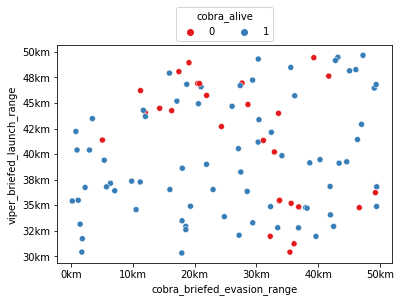

In [11]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_evasion_range",
    y="viper_briefed_launch_range",
    hue="cobra_alive",
    palette="Set1"
)
sns.move_legend(ax, "upper center", ncol=2, bbox_to_anchor=(0.5, 1.2))
xlabels = ['{:,.0f}'.format(x) + 'km' for x in ax.get_xticks()/1000]
_ = ax.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) + 'km' for y in ax.get_yticks()/1000]
_ = ax.set_yticklabels(ylabels)

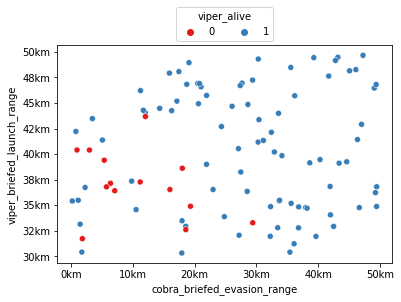

In [12]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_evasion_range",
    y="viper_briefed_launch_range",
    hue="viper_alive",
    palette="Set1"
)
sns.move_legend(ax, "upper center", ncol=2, bbox_to_anchor=(0.5, 1.2))
xlabels = ['{:,.0f}'.format(x) + 'km' for x in ax.get_xticks()/1000]
_ = ax.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(y) + 'km' for y in ax.get_yticks()/1000]
_ = ax.set_yticklabels(ylabels)

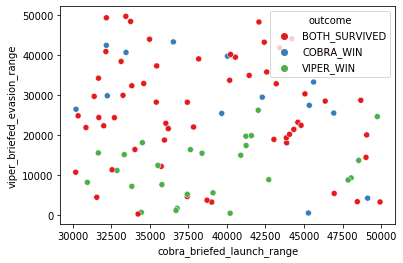

In [13]:
ax = sns.scatterplot(
    data=df,
    x="cobra_briefed_launch_range",
    y="viper_briefed_evasion_range",
    hue="outcome",
    palette="Set1"
)